<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">Otimização do Modelo SARIMA</font></b></strong>

No modelo 18 criamos um Modelo SARIMA aplicando Grid Search Stepwise para buscar os melhores valores dos hiperparâmetros.

Agora, vamos tentar melhorar a performance do modelo criado mudando a estratégia do Grid Search.  

In [2]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

from time import time
from datetime import datetime
from datetime import date, timedelta

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

statsmodels: 0.12.2
pandas     : 1.2.4
sys        : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
matplotlib : 3.3.4
sklearn    : 1.1.1
numpy      : 1.19.5
scipy      : 1.6.2



## Definição do Problema de Negócio

Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

In [4]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)

# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

filtro1 = dataframe['Broker']=='ETB170'
filtro2 = dataframe['Service_name']=='PORTALDETRAN'
filtro3 = dataframe['Programa']=='NSDGX500'
dataframe = dataframe[filtro1 & filtro2 & filtro3]

dataframe = dataframe.rename_axis('index').reset_index()
dataframe.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataframe.drop_duplicates(subset='Data', inplace=True)
dataframe = dataframe.set_index('Data')
dataframe = dataframe.resample('D').interpolate()

In [5]:
# Dados
dataframe.head()

,Quantidade
Data,
2021-10-26,162.0
2021-10-27,66.0
2021-10-28,58.0
2021-10-29,44.0
2021-10-30,83.0


In [6]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['Quantidade']

In [7]:
# Random seed 
np.random.seed(7)

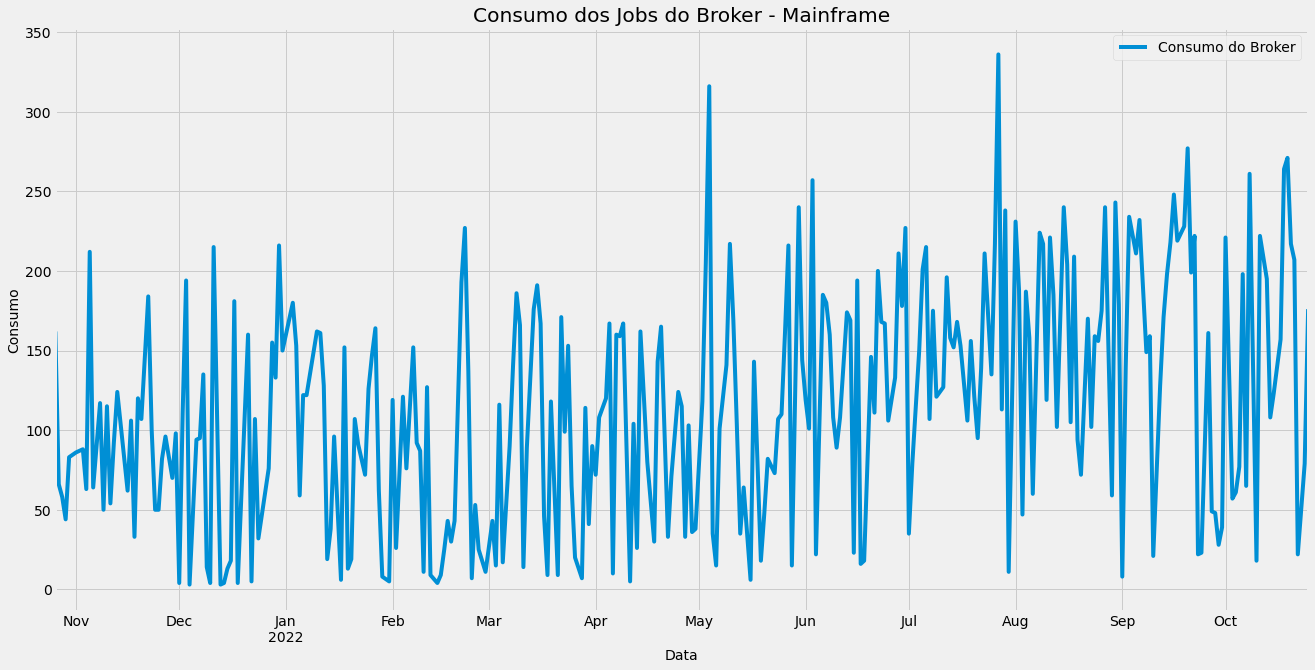

In [8]:
# Plot
target.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

In [9]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

273 92


In [10]:
# Aplicando transformação de log
#treino_log = np.log(treino) 

In [11]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
#teste_log = np.log(teste)

In [12]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Otimização do Modelo SARIMA

### Grid Search Método 2 

Neste método de Grid Search, nós testamos diversas combinações dos hiperparâmetros do modelo SARIMA. Tome cuidado para não exagerar nas combinações. Valores de 0 e 1 resolvem a grande maioria dos problemas.

In [14]:
# Vamos definir p, d e q para que tenham valores entre 0 e 2 e testaremos as combinações.
p = d = q = range(0, 3)

Agora geramos diferentes combinações de p, d e q.

In [15]:
# Lista de combinações de p, d, q
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [16]:
# Lista de combinações dos hiperparâmetros sazonais P, D e Q
# Estamos usando List Comprehension
seasonal_pdq = [(x[0], x[1], x[2], 10) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 10),
 (0, 0, 1, 10),
 (0, 0, 2, 10),
 (0, 1, 0, 10),
 (0, 1, 1, 10),
 (0, 1, 2, 10),
 (0, 2, 0, 10),
 (0, 2, 1, 10),
 (0, 2, 2, 10),
 (1, 0, 0, 10),
 (1, 0, 1, 10),
 (1, 0, 2, 10),
 (1, 1, 0, 10),
 (1, 1, 1, 10),
 (1, 1, 2, 10),
 (1, 2, 0, 10),
 (1, 2, 1, 10),
 (1, 2, 2, 10),
 (2, 0, 0, 10),
 (2, 0, 1, 10),
 (2, 0, 2, 10),
 (2, 1, 0, 10),
 (2, 1, 1, 10),
 (2, 1, 2, 10),
 (2, 2, 0, 10),
 (2, 2, 1, 10),
 (2, 2, 2, 10)]

In [17]:
print('\nExemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:\n')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Exemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:

SARIMAX: (0, 0, 1) x (0, 0, 1, 10)
SARIMAX: (0, 0, 1) x (0, 0, 2, 10)
SARIMAX: (0, 0, 2) x (0, 1, 0, 10)
SARIMAX: (0, 0, 2) x (0, 1, 1, 10)


In [18]:
# Grid Search
warnings.filterwarnings("ignore")

start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

# Menor valor possível para a estatística AIC (nosso objetivo na otimização do modelo)
lowest_aic = sys.maxsize
lowest = ''

# Loop
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            # Cria o modelo com a combinação dos hiperparâmetros
            mod = sm.tsa.statespace.SARIMAX(treino,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
            # Treina o modelo
            results = mod.fit()
            
            # Print
            print('SARIMA{}x{}10 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # Coleta o menor valor de AIC
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{}10 - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("\nModelo com Menor Valor de AIC: " + lowest)


current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)    
print ('Tempo gasto: %s segundos' % str(time() - start))


Hora de Início = 22:14:58
SARIMA(0, 0, 0)x(0, 0, 0, 10)10 - AIC:3364.823269653428
SARIMA(0, 0, 0)x(0, 0, 1, 10)10 - AIC:3149.3355541346555
SARIMA(0, 0, 0)x(0, 0, 2, 10)10 - AIC:2999.0999697723305
SARIMA(0, 0, 0)x(0, 1, 0, 10)10 - AIC:3080.323054017613
SARIMA(0, 0, 0)x(0, 1, 1, 10)10 - AIC:2823.7227033748927
SARIMA(0, 0, 0)x(0, 1, 2, 10)10 - AIC:2713.2913904018433
SARIMA(0, 0, 0)x(0, 2, 0, 10)10 - AIC:3251.1020717457386
SARIMA(0, 0, 0)x(0, 2, 1, 10)10 - AIC:2885.369104545194
SARIMA(0, 0, 0)x(0, 2, 2, 10)10 - AIC:2649.7284151043123
SARIMA(0, 0, 0)x(1, 0, 0, 10)10 - AIC:3060.104414040514
SARIMA(0, 0, 0)x(1, 0, 1, 10)10 - AIC:2931.8873781922434
SARIMA(0, 0, 0)x(1, 0, 2, 10)10 - AIC:2824.933710609009
SARIMA(0, 0, 0)x(1, 1, 0, 10)10 - AIC:2900.6495314090994
SARIMA(0, 0, 0)x(1, 1, 1, 10)10 - AIC:2824.9764900503524
SARIMA(0, 0, 0)x(1, 1, 2, 10)10 - AIC:2715.1673277118653
SARIMA(0, 0, 0)x(1, 2, 0, 10)10 - AIC:2997.1066050316067
SARIMA(0, 0, 0)x(1, 2, 1, 10)10 - AIC:2816.993596676766
SARIMA(0, 0

SARIMA(0, 1, 2)x(1, 0, 1, 10)10 - AIC:2855.2074761580134
SARIMA(0, 1, 2)x(1, 0, 2, 10)10 - AIC:2752.932969119298
SARIMA(0, 1, 2)x(1, 1, 0, 10)10 - AIC:2878.7604725051583
SARIMA(0, 1, 2)x(1, 1, 1, 10)10 - AIC:2773.907083644796
SARIMA(0, 1, 2)x(1, 1, 2, 10)10 - AIC:2666.0210489800183
SARIMA(0, 1, 2)x(1, 2, 0, 10)10 - AIC:2973.0208979736835
SARIMA(0, 1, 2)x(1, 2, 1, 10)10 - AIC:2775.667147226158
SARIMA(0, 1, 2)x(1, 2, 2, 10)10 - AIC:2606.336126930087
SARIMA(0, 1, 2)x(2, 0, 0, 10)10 - AIC:2783.060346392775
SARIMA(0, 1, 2)x(2, 0, 1, 10)10 - AIC:2784.884974546525
SARIMA(0, 1, 2)x(2, 0, 2, 10)10 - AIC:2754.928314520511
SARIMA(0, 1, 2)x(2, 1, 0, 10)10 - AIC:2729.1502108147306
SARIMA(0, 1, 2)x(2, 1, 1, 10)10 - AIC:2699.217418039066
SARIMA(0, 1, 2)x(2, 1, 2, 10)10 - AIC:2664.8744263850867
SARIMA(0, 1, 2)x(2, 2, 0, 10)10 - AIC:2767.5954494663642
SARIMA(0, 1, 2)x(2, 2, 1, 10)10 - AIC:2660.3116199745236
SARIMA(0, 1, 2)x(2, 2, 2, 10)10 - AIC:2608.0133485571205
SARIMA(0, 2, 0)x(0, 0, 0, 10)10 - AIC:3

SARIMA(1, 0, 1)x(2, 1, 0, 10)10 - AIC:2721.355163735582
SARIMA(1, 0, 1)x(2, 1, 1, 10)10 - AIC:2696.7451987183094
SARIMA(1, 0, 1)x(2, 1, 2, 10)10 - AIC:2684.78054566869
SARIMA(1, 0, 1)x(2, 2, 0, 10)10 - AIC:2761.484211641629
SARIMA(1, 0, 1)x(2, 2, 1, 10)10 - AIC:2652.14049617394
SARIMA(1, 0, 1)x(2, 2, 2, 10)10 - AIC:2628.568237400237
SARIMA(1, 0, 2)x(0, 0, 0, 10)10 - AIC:2968.8289021379505
SARIMA(1, 0, 2)x(0, 0, 1, 10)10 - AIC:2864.054466291197
SARIMA(1, 0, 2)x(0, 0, 2, 10)10 - AIC:2763.747046000859
SARIMA(1, 0, 2)x(0, 1, 0, 10)10 - AIC:3040.965218213394
SARIMA(1, 0, 2)x(0, 1, 1, 10)10 - AIC:2784.3672804695707
SARIMA(1, 0, 2)x(0, 1, 2, 10)10 - AIC:2676.351661383744
SARIMA(1, 0, 2)x(0, 2, 0, 10)10 - AIC:3208.9291706762983
SARIMA(1, 0, 2)x(0, 2, 1, 10)10 - AIC:2844.9671085367972
SARIMA(1, 0, 2)x(0, 2, 2, 10)10 - AIC:2614.255267410375
SARIMA(1, 0, 2)x(1, 0, 0, 10)10 - AIC:2889.5570980522616
SARIMA(1, 0, 2)x(1, 0, 1, 10)10 - AIC:2867.9919204340576
SARIMA(1, 0, 2)x(1, 0, 2, 10)10 - AIC:2765.

SARIMA(1, 2, 1)x(0, 1, 2, 10)10 - AIC:2740.6053319536218
SARIMA(1, 2, 1)x(0, 2, 0, 10)10 - AIC:3275.1566295442417
SARIMA(1, 2, 1)x(0, 2, 1, 10)10 - AIC:2911.4399525847066
SARIMA(1, 2, 1)x(0, 2, 2, 10)10 - AIC:2680.09338612148
SARIMA(1, 2, 1)x(1, 0, 0, 10)10 - AIC:2945.1575066507057
SARIMA(1, 2, 1)x(1, 0, 1, 10)10 - AIC:2936.844988757059
SARIMA(1, 2, 1)x(1, 0, 2, 10)10 - AIC:2831.141279481703
SARIMA(1, 2, 1)x(1, 1, 0, 10)10 - AIC:2926.439581072202
SARIMA(1, 2, 1)x(1, 1, 1, 10)10 - AIC:2852.0453520581077
SARIMA(1, 2, 1)x(1, 1, 2, 10)10 - AIC:2738.665827722406
SARIMA(1, 2, 1)x(1, 2, 0, 10)10 - AIC:3011.8162596548505
SARIMA(1, 2, 1)x(1, 2, 1, 10)10 - AIC:2842.4582600112503
SARIMA(1, 2, 1)x(1, 2, 2, 10)10 - AIC:2681.7966294276357
SARIMA(1, 2, 1)x(2, 0, 0, 10)10 - AIC:2839.882790264571
SARIMA(1, 2, 1)x(2, 0, 1, 10)10 - AIC:2841.5421792807156
SARIMA(1, 2, 1)x(2, 0, 2, 10)10 - AIC:2832.297003129383
SARIMA(1, 2, 1)x(2, 1, 0, 10)10 - AIC:2781.7054851279872
SARIMA(1, 2, 1)x(2, 1, 1, 10)10 - AIC:2

SARIMA(2, 1, 0)x(1, 2, 0, 10)10 - AIC:2995.7212440841445
SARIMA(2, 1, 0)x(1, 2, 1, 10)10 - AIC:2832.775407762
SARIMA(2, 1, 0)x(1, 2, 2, 10)10 - AIC:2678.3858582918656
SARIMA(2, 1, 0)x(2, 0, 0, 10)10 - AIC:2815.084416521991
SARIMA(2, 1, 0)x(2, 0, 1, 10)10 - AIC:2816.945226191817
SARIMA(2, 1, 0)x(2, 0, 2, 10)10 - AIC:2818.9415964860236
SARIMA(2, 1, 0)x(2, 1, 0, 10)10 - AIC:2757.3360958637195
SARIMA(2, 1, 0)x(2, 1, 1, 10)10 - AIC:2727.6903560409824
SARIMA(2, 1, 0)x(2, 1, 2, 10)10 - AIC:2726.2761873328955
SARIMA(2, 1, 0)x(2, 2, 0, 10)10 - AIC:2794.308915852501
SARIMA(2, 1, 0)x(2, 2, 1, 10)10 - AIC:2684.7823233609333
SARIMA(2, 1, 0)x(2, 2, 2, 10)10 - AIC:2669.1319398982105
SARIMA(2, 1, 1)x(0, 0, 0, 10)10 - AIC:2970.5978137120414
SARIMA(2, 1, 1)x(0, 0, 1, 10)10 - AIC:2865.683180721425
SARIMA(2, 1, 1)x(0, 0, 2, 10)10 - AIC:2764.745649447955
SARIMA(2, 1, 1)x(0, 1, 0, 10)10 - AIC:3045.4649166787585
SARIMA(2, 1, 1)x(0, 1, 1, 10)10 - AIC:2784.408945993664
SARIMA(2, 1, 1)x(0, 1, 2, 10)10 - AIC:267

SARIMA(2, 2, 2)x(2, 2, 2, 10)10 - AIC:2851.926695235927

Modelo com Menor Valor de AIC: SARIMA(0, 1, 2)x(0, 2, 2, 10)10 - AIC:2605.3622087619688

Hora de Término = 22:35:37
Tempo gasto: 1238.7291185855865 segundos


In [19]:
# Treina o modelo com a melhor combinação de hiperparâmetros
modelo_sarima_v2 = sm.tsa.statespace.SARIMAX(treino,
                                             order = (0, 1, 2),
                                             seasonal_order = (0, 2, 2, 10),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

In [20]:
# Treinamento (Fit) do modelo
modelo_sarima_v2_fit = modelo_sarima_v2.fit()

In [21]:
# Sumário do modelo
print(modelo_sarima_v2_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Quantidade   No. Observations:                  273
Model:             SARIMAX(0, 1, 2)x(0, 2, 2, 10)   Log Likelihood               -1297.681
Date:                            Thu, 27 Oct 2022   AIC                           2605.362
Time:                                    22:40:05   BIC                           2622.531
Sample:                                10-26-2021   HQIC                          2612.288
                                     - 07-25-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7313    271.348     -0.003      0.998    -532.564     531.102
ma.L2         -0.2688     72.901   

Nas próximas aulas vamos interpretar o sumário do modelo e comparar as versões dos modelos SARIMA que iremos criar.

Mas perceba o valor de AIC. Conseguimos reduzí-lo de forma considerável e a única mudança foi a otimizaçã dos hiperparâmetros.

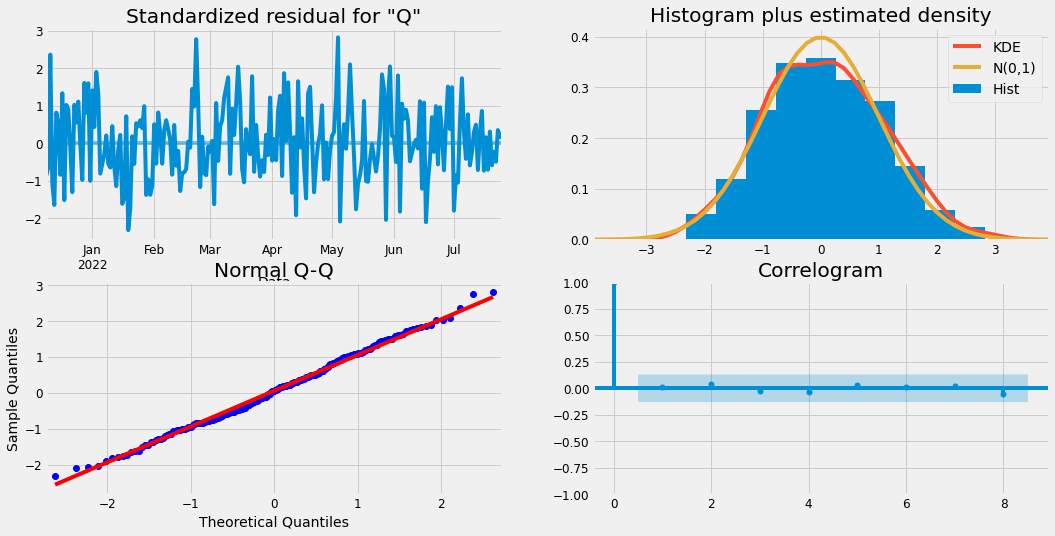

In [22]:
# Diagnóstico do modelo
modelo_sarima_v2_fit.plot_diagnostics(lags = 8, figsize = (16,8))
plt.show()

**Diagnóstico do Modelo:**

- Nossa principal preocupação é garantir que os resíduos do nosso modelo não sejam correlacionados e sejam normalmente distribuídos com média zero.

- Se o modelo SARIMA não atender a essas propriedades, é uma boa indicação de que pode ser melhorado ainda mais.

O diagnóstico do modelo sugere que o resíduo do modelo é normalmente distribuído com base no seguinte:

- No gráfico superior direito, a linha azul do KDE segue de perto a linha N (0,1). Onde N (0,1) é a notação padrão para uma distribuição normal com média 0 e desvio padrão de 1. Essa é uma boa indicação de que os resíduos são normalmente distribuídos.

- O gráfico qq no canto inferior esquerdo mostra que a distribuição ordenada de resíduos (pontos azuis) segue a tendência linear das amostras coletadas de uma distribuição normal padrão. Novamente, essa é uma forte indicação de que os resíduos são normalmente distribuídos.

- Os resíduos ao longo do tempo (gráfico superior esquerdo) não exibem nenhuma sazonalidade óbvia e parecem ser ruído branco.

- Isso é confirmado pelo gráfico de autocorrelação (isto é, correlograma) no canto inferior direito, que mostra que os resíduos da série temporal têm baixa correlação com versões atrasadas de si.

In [23]:
# Última data da série
fim = target.index[-1]
td = timedelta(len(teste))
inicio=fim - td
print("inicio: ", inicio, " fim : ", fim, "n dias: ", td)

inicio:  2022-07-25 00:00:00  fim :  2022-10-25 00:00:00 n dias:  92 days, 0:00:00


In [25]:
# Previsões com o modelo
# Última data da série
fim = target.index[-1]
td = timedelta(len(teste))
inicio=fim - td
sarima_predict_2 = modelo_sarima_v2_fit.get_prediction(start = inicio, end = fim, dynamic = False)

In [26]:
# Intervalo de confiança
sarima_predict_conf_2 = sarima_predict_2.conf_int()
#sarima_predict_conf_2

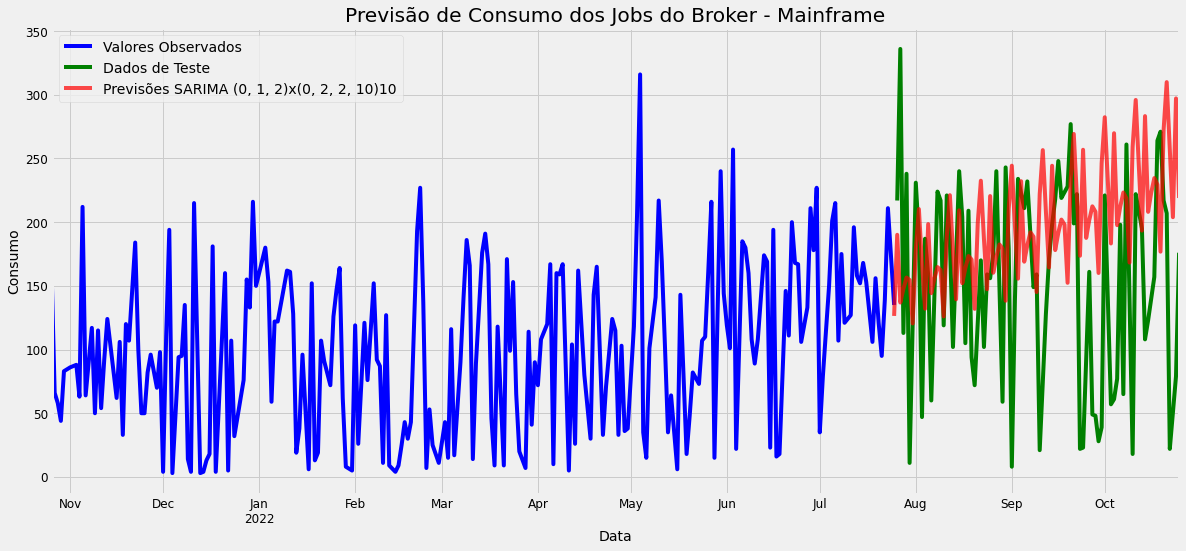

In [28]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 8

ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
sarima_predict_2.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA (0, 1, 2)x(0, 2, 2, 10)10' , 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
#ax.fill_between(sarima_predict_conf_2.index,
#                # lower sales
#                sarima_predict_conf_2.iloc[:, 0],
#                # upper sales
#                sarima_predict_conf_2.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão de Consumo dos Jobs do Broker - Mainframe')
plt.xlabel('Data')
plt.ylabel('Consumo')
plt.legend()
plt.show()

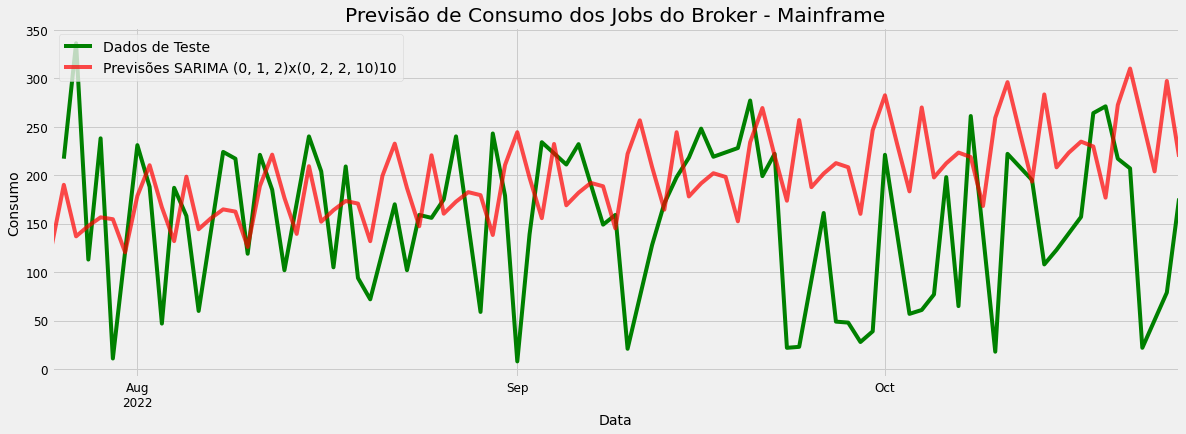

In [29]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 6

#ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
sarima_predict_2.predicted_mean.plot(ax = t, 
                                     label = 'Previsões SARIMA (0, 1, 2)x(0, 2, 2, 10)10', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Títulos e Legendas
plt.title('Previsão de Consumo dos Jobs do Broker - Mainframe')
plt.xlabel('Data')
plt.ylabel('Consumo')
plt.legend(loc = 'upper left')
plt.show()

Embora ainda não esteja ideal, o modelo fez um bom trabalho nas previsões.

In [33]:
# Calculando a performance
sarima_results = performance(treino, sarima_predict_2.predicted_mean)
#sarima_results

MSE das previsões é 74.0252
RMSE das previsões é 8.6038
MAPE das previsões é 6.3732


In [34]:
# Calculando a performance
sarima_results = performance(teste, sarima_predict_2.predicted_mean)
#sarima_results

MSE das previsões é 10226.1815
RMSE das previsões é 101.1246
MAPE das previsões é 169.9647


O erro do modelo aumentou um pouco, mas não podemos usar apenas uma medida para avaliar o modelo. Falaremos mais sobre isso nas aulas seguintes. Vejamos como o modelo se sai em um horizonte de previsão maior.

In [35]:
# Forecast (previsão) de 60 passos no tempo
horizonte_60_predict_2 = modelo_sarima_v2_fit.get_forecast(steps = 82)

In [36]:
# Intervalo de confiança
horizonte_60_predict_2_conf_2 = horizonte_60_predict_2.conf_int()
#horizonte_60_predict_2_conf_2

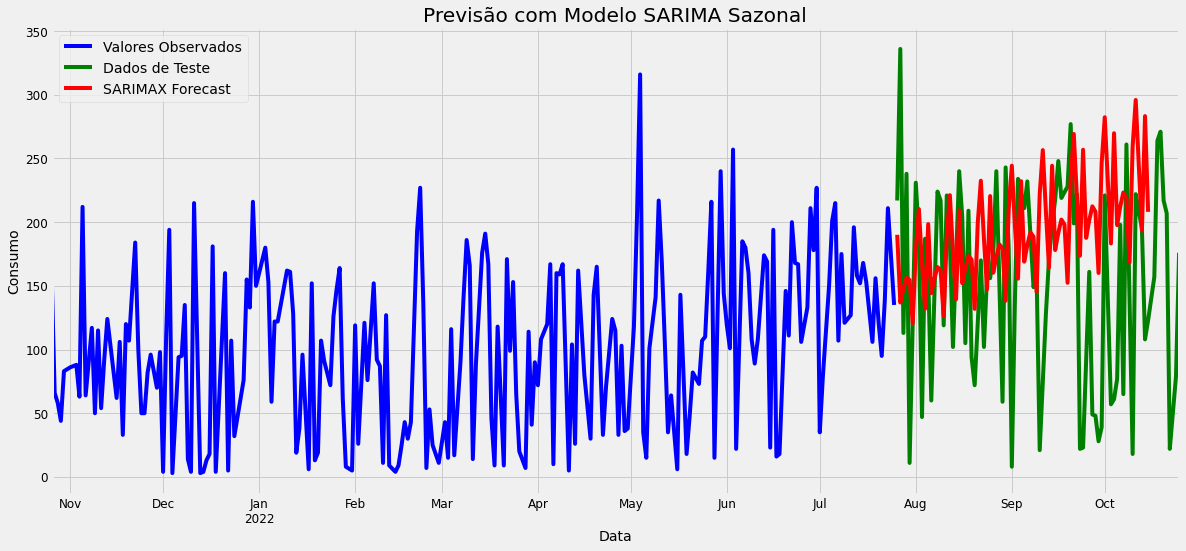

In [37]:
# Plot dos valores observados

rcParams['figure.figsize'] = 18, 8

ax = treino.plot(label = 'Valores Observados', color = 'blue')

t = teste.plot(label = 'Dados de Teste', color = 'green')

# Plot dos valores previstos
horizonte_60_predict_2.predicted_mean.plot(ax = ax, label = 'SARIMAX Forecast', color = 'red')

# Plot do intervalo de confiança
#ax.fill_between(horizonte_60_predict_2_conf_2.index,
#                horizonte_60_predict_2_conf_2.iloc[:, 0],
#                horizonte_60_predict_2_conf_2.iloc[:, 1], color = 'k', alpha = .25)

# Plot
plt.title('Previsão com Modelo SARIMA Sazonal')
ax.set_xlabel('Data')
ax.set_ylabel('Consumo')
plt.legend(loc = 'upper left')
plt.show()

Por que a área cinza aumenta? Porque quanto maior o horizonte de previsão, maior a incerteza das previsões. Veja que estamos fazendo previsões de vendas para 5 anos (60 passos no tempo em nossa série), o que aumenta a incerteza a cada novo passo de tempo previsto.

In [38]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_sarima_v2_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.20772864]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95%. 

O modelo SARIMA (0, 1, 2)x(0, 2, 2, 10) fornece um bom ajuste e boa capacidade de previsão.

Como estamos até agora:

- Modelo 15 --> Modelo ARMA (9, 6) - AIC = 1295.100 e RMSE = 3.5966
- Modelo 16 --> Modelo ARIMA Forcast (4, 1, 5) Forecast - AIC = 1385.134 e RMSE = 3.7513
- Modelo 17 --> Modelo SARIMA (2, 1, 1)x(2, 1, 0, 10) - AIC = 1449.398 e RMSE = 6.5842
- Modelo 18 --> Modelo SARIMA (1, 1, 1)x(0, 1, 1, 10) - AIC = 1451.114 e RMSE = 5.0104

Que diferença faz uma otimização de hiperparâmetros, não é verdade? Incrível como conseguimos melhorar a performance do nosso modelo aplicando técnicas de otimização.

Embora não seja o caso aqui, se tivermos discrepâncias entre o AIC e o RMSE, nossa escolha deve ser pelo AIC.

O RMSE é o erro do modelo com os dados atuais, de teste.

O AIC avalia a performance global do modelo e a sua capacidade de prever em um horizonte de previsão além das amostra de teste (ou seja, com novos dados). E isso é o que queremos! Logo, havendo discrepância das métricas, devemos escolher o modelo com menor AIC.

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim